In [38]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(palette='Set2')
import plotly.graph_objects as go
# import plotly.io as pio
# pio.renderers.default = "svg"

from sklearn.metrics import log_loss, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.datasets import make_classification

from itertools import product

from typing import List, Any, Tuple, Optional

import warnings
warnings.filterwarnings('ignore')

import nbimporter
from Functions import PurgedKFold, cvScore

## Auxilary Functions

In [39]:
def feat_imp_MDI(fit: Any, featNames: np.ndarray) -> pd.DataFrame:
    '''
    Calculates mean feature importances based on MDI.
    
        Parameters:
            fit (Any): classifier (needs to be tree-based, e.g. Random Forest)
            featNames (np.ndarray): list with feature names
        
        Returns:
            imp (pd.DataFrame): dataframe with mean and std of importance for each feature
    '''
    df0 = {i: tree.feature_importances_ for i, tree in enumerate(fit.estimators_)}
    df0 = pd.DataFrame.from_dict(df0, orient='index')
    df0.columns = featNames
    df0 = df0.replace(0, np.nan)    # because max_features=1
    imp = pd.concat({'mean': df0.mean(), 'std': df0.std() * df0.shape[0] ** (-0.5)}, axis=1)
    imp /= imp['mean'].sum()
    return imp

In [40]:
def feat_imp_MDA(
    clf: Any, X: pd.DataFrame, y: pd.Series, cv: int, sample_weight: pd.Series,
    t1: pd.Series, pctEmbargo: float, scoring: str = 'neg_log_loss'
) -> Tuple[pd.DataFrame, float]:
    '''
    Calculates mean feature importances based on OOS score reduction
    while also fitting and evaluating classifier.
    
        Parameters:
            clf (Any): model we want to fit
            X (pd.DataFrame): feature matrix
            y (pd.Series): labels
            cv (int): number of splits
            sample_weight (pd.Series): sample weights
            t1 (pd.Series): start timestamps (t1.index) and end timestamps (t1.values) of observations
            pctEmbargo (float): share of observations to drop after test
            scoring (str): score we want to compute
        
        Returns:
            imp (pd.DataFrame): dataframe with mean and std of importance for each feature
            scr0.mean() (float): mean CV score of classifier
    '''
    if scoring not in ['neg_log_loss', 'accuracy']:
        raise Exception('wrong scoring method.')
    cvGen = PurgedKFold(n_splits=cv, t1=t1, pctEmbargo=pctEmbargo)    # purged cv
    scr0, scr1 = pd.Series(), pd.DataFrame(columns=X.columns, dtype=object)
    
    for i, (train, test) in enumerate(cvGen.split(X=X)):
        X0, y0, w0 = X.iloc[train, :], y.iloc[train], sample_weight.iloc[train]
        X1, y1, w1 = X.iloc[test, :], y.iloc[test], sample_weight.iloc[test]
        fit = clf.fit(X=X0, y=y0, sample_weight=w0.values)
        if scoring == 'neg_log_loss':
            prob = fit.predict_proba(X1)
            scr0.loc[i] = -log_loss(y1, prob, sample_weight=w1.values, labels=clf.classes_)
        else:
            pred = fit.predict(X1)
            scr0.loc[i] = accuracy_score(y1, pred, sample_weight=w1.values)
        for j in X.columns:
            X1_ = X1.copy(deep=True)
            np.random.shuffle(X1_[j].values)    # permutation of a single column
            if scoring == 'neg_log_loss':
                prob = fit.predict_proba(X1_)
                scr1.loc[i, j] = -log_loss(y1, prob, sample_weight=w1.values, labels=clf.classes_)
            else:
                pred = fit.predict(X1_)
                scr1.loc[i, j] = accuracy_score(y1, pred, sample_weight=w1.values)
    imp = (-scr1).add(scr0, axis=0)
    if scoring == 'neg_log_loss':
        imp = imp / -scr1
    else:
        imp = imp / (1.0 - scr1)
    imp = pd.concat({'mean': imp.mean(), 'std': imp.std() * imp.shape[0] ** (-0.5)}, axis=1)
    return imp, scr0.mean()

In [41]:
def aux_feat_imp_SFI(
    featNames: np.ndarray, clf: Any, trnsX: pd.DataFrame, cont: pd.DataFrame, scoring: str, cvGen: PurgedKFold
) -> pd.DataFrame:
    '''
    Calculates mean feature importances based on Single Feature Importance (SFI).
    
        Parameters:
            featNames (np.ndarray): list with feature names
            clf (Any): model we want to fit
            trnsX (pd.DataFrame): train dataset
            cont (pd.DataFrame): dataframe with observation labels and weights
            scoring (str): scoring function used for evaluation
            cvGen (PurgedKFold): CV generator (purged)
        
        Returns:
            imp (pd.DataFrame): dataframe with mean and std of importance for each feature
    '''
    imp = pd.DataFrame(columns=['mean', 'std'], dtype=object)
    for featName in featNames:
        df0 = cvScore(clf, X=trnsX[[featName]], y=cont['bin'], sample_weight=cont['w'], scoring=scoring, cvGen=cvGen)
        imp.loc[featName, 'mean'] = df0.mean()
        imp.loc[featName, 'std'] = df0.std() * df0.shape[0] ** (-0.5)
    return imp

In [42]:
def get_eVec(dot: np.ndarray, varThres: float) -> Tuple[np.ndarray, np.ndarray]:
    '''
    Calculates eigenvalues and eigenvectors of dot product matrix that explain varThres of its variance.
    
        Parameters:
            dot (np.ndarray): feature matrix
            varThres (float): share of variance we want to explain
        
        Returns:
            eVal (np.ndarray): eigenvalues
            eVec (np.ndarray): eigenvectors
    '''
    eVal, eVec = np.linalg.eigh(dot)
    idx = eVal.argsort()[::-1]    # arguments for sorting eVal desc
    eVal, eVec = eVal[idx], eVec[:, idx]
    eVal = pd.Series(eVal, index=['PC_' + str(i + 1) for i in range(eVal.shape[0])])
    eVec = pd.DataFrame(eVec, index=dot.index, columns=eVal.index)
    eVec = eVec.loc[:, eVal.index]
    cumVar = eVal.cumsum() / eVal.sum()
    dim = cumVar.values.searchsorted(varThres)
    eVal, eVec = eVal.iloc[:dim + 1], eVec.iloc[:, :dim + 1]
    return eVal, eVec


def ortho_feats(dfX: pd.DataFrame, varThres: float = 0.95) -> pd.DataFrame:
    '''
    Given a dataframe dfX of features, compute orthogonal features dfP explaining varThres of variance.
    
        Parameters:
            dfX (pd.DataFrame): feature matrix
            varThres (float): share of variance we want to explain
        
        Returns:
            dfP (pd.DataFrame): orthogonal features
    '''
    dfZ = dfX.sub(dfX.mean(), axis=1).div(dfX.std(), axis=1)    # standardize
    dot = pd.DataFrame(np.dot(dfZ.T, dfZ), index=dfX.columns, columns=dfX.columns)
    eVal, eVec = get_eVec(dot, varThres)
    dfP = np.dot(dfZ, eVec)
    return pd.DataFrame(dfP)

In [43]:
def get_test_data(n_features: int = 40, n_informative: int = 10,
                  n_redundant: int = 10, n_samples: int = 10000) -> Tuple[pd.DataFrame, pd.DataFrame]:
    '''
    Generate a synthetic dataset with given types of features.
    
        Parameters:
            n_features (int): total number of features
            n_informative (int): number of informative features
            n_redundant (int): number of redundant features (linear combinations of informative features)
            n_samples (int): number of observations
        
        Returns:
            trnsX (pd.DataFrame): synthetic dataset
            cont (pd.DataFrame): dataframe with labels ('bin'), weights, and t1 timestamps
    '''
    trnsX, cont = make_classification(n_samples=n_samples, n_features=n_features, n_informative=n_informative,
                                      n_redundant=n_redundant, random_state=0, shuffle=False)
    trnsX, cont = pd.DataFrame(trnsX), pd.Series(cont).to_frame('bin')
    df0 = ['I_' + str(i) for i in range(n_informative)] + ['R_' + str(i) for i in range(n_redundant)]
    df0 += ['N_' + str(i) for i in range(n_features - len(df0))]
    trnsX.columns = df0
    cont['w'] = 1.0 / cont.shape[0]
    cont['t1'] = pd.Series(cont.index, index=cont.index)
    return trnsX, cont

In [44]:
# no multiprocessing here
def feat_importance(
    trnsX: pd.DataFrame, cont: pd.DataFrame, n_estimators: int = 100, cv: int = 10,
    max_samples: float = 1.0, pctEmbargo: float = 0.0, scoring: str = 'accuracy',
    method: str = 'SFI', min_weight_fraction_leaf: float = 0.0, ensemble: str = 'bagging'
) -> Tuple[pd.DataFrame, float, float]:
    '''
    Calculate feature importance using given method using bagged decision trees.
    
        Parameters:
            ensemble (str): model type (decision trees bagging or random forest)
            trnsX (pd.DataFrame): train dataset
            cont (pd.DataFrame): dataframe with labels ('bin'), weights, and t1 timestamps
            n_estimators (int): number of trees
            cv (int): number of CV splits
            max_samples (float): share of samples to draw from X to train each base estimator
            pctEmbargo (float): share of observations to drop after test (embargo period)
            scoring (str): scoring/loss function
            method (str): method used to calculate feature importance
            min_weight_fraction_leaf (float): minimum fraction of the sum of weights required to be at a leaf node
        
        Returns:
            imp (pd.DataFrame): dataframe with mean and std of importance for each feature
            oob (float): out-of-bag classifier score
            oos (float): mean CV score
    '''
    if ensemble == 'bagging':
        clf = DecisionTreeClassifier(criterion='entropy', max_features=1, class_weight='balanced',
                                     min_weight_fraction_leaf=min_weight_fraction_leaf)
        clf = BaggingClassifier(base_estimator=clf, n_estimators=n_estimators, max_features=1.0,
                                max_samples=max_samples, oob_score=True, n_jobs=-1)
    else:
        clf = RandomForestClassifier(n_estimators=n_estimators, criterion='entropy',
                                     min_weight_fraction_leaf=min_weight_fraction_leaf,
                                     max_features=1, oob_score=True, n_jobs=-1, max_samples=max_samples)
    fit = clf.fit(X=trnsX, y=cont['bin'], sample_weight=cont['w'].values)
    oob = fit.oob_score_
    
    if method == 'MDI':
        imp = feat_imp_MDI(fit, featNames=trnsX.columns)
        oos = cvScore(clf, X=trnsX, y=cont['bin'], cv=cv, sample_weight=cont['w'], t1=cont['t1'],
                      pctEmbargo=pctEmbargo, scoring=scoring).mean()
        
    elif method=='MDA':
        imp, oos = feat_imp_MDA(clf, X=trnsX, y=cont['bin'], cv=cv, sample_weight=cont['w'], t1=cont['t1'],
                                pctEmbargo=pctEmbargo, scoring=scoring)
        
    elif method=='SFI':
        cvGen = PurgedKFold(n_splits=cv, t1=cont['t1'], pctEmbargo=pctEmbargo)
        oos = cvScore(clf, X=trnsX, y=cont['bin'], sample_weight=cont['w'],
                      scoring=scoring, cvGen=cvGen).mean()
        imp = aux_feat_imp_SFI(featNames=trnsX.columns, clf=clf, trnsX=trnsX, cont=cont,
                               scoring=scoring, cvGen=cvGen)
    
    return imp, oob, oos

In [45]:
def plot_feat_importance(
    imp: pd.DataFrame, oob: float, oos: float, method: str,
    tag: str = 'test_func', simNum: Optional[str] = None
) -> None:
    '''
    Plots mean feature importance bars with std.
    
        Parameters:
            imp (pd.DataFrame): feature importance
            oob (float): out-of-bag score
            oos (float): mean CV score
            method (str): method to calculate feature importance
            tag (str): tag for title
            simNum (str): reference for simulation parameters
    '''
    fig, ax = plt.subplots(figsize=(10, imp.shape[0] / 5))
    imp = imp.sort_values('mean', ascending=True)
    ax.barh(y=imp.index, width=imp['mean'], color='b', alpha=0.25, xerr=imp['std'], error_kw={'ecolor':'r'})
    if method=='MDI':
        ax.set_xlim(left=0, right=imp.sum(axis=1).max())
        ax.axvline(1.0 / imp.shape[0], linewidth=1, color='r', linestyle='dotted')
    ax.get_yaxis().set_visible(False)
    for i, j in zip(ax.patches, imp.index):
        ax.text(i.get_width() / 2, i.get_y() + i.get_height() / 2, j, ha='center', va='center', color='black')
    ax.set_title(f'tag={tag} | simNum={simNum} | oob={str(round(oob, 4))} | oos={str(round(oos,4))}')
    plt.show()

In [46]:
def test_func(n_features: int = 40, n_informative: int = 10, n_redundant: int = 10,
              n_estimators: int = 100, n_samples: int = 10000, cv: int = 10) -> pd.DataFrame:
    '''
    Run 3 methods to calculate feature importance on synthetic dataset and print the results.
    
        Parameters:
            n_features (int): total number of features
            n_informative (int): number of informative features
            n_redundant (int): number of redundant features (linear combinations of informative features)
            n_estimators (int): number of trees
            n_samples (int): number of observations
            cv (int): number of CV splits
        
        Returns:
            out (pd.DataFrame): dataframe with stats on each method
    '''
    trnsX, cont = get_test_data(n_features, n_informative, n_redundant, n_samples)
    dict0 = {'minWLeaf': [0.0], 'scoring': ['accuracy'], 'method': ['MDI', 'MDA', 'SFI'], 'max_samples': [1.0]}
    jobs, out = (dict(zip(dict0, i)) for i in product(*dict0.values())), []
    
    for job in jobs:
        job['simNum'] = job['method'] +'_' + job['scoring'] + '_' + '%.2f'%job['minWLeaf'] + \
                        '_' + str(job['max_samples'])
        print(job['simNum'])
        imp, oob, oos = feat_importance(trnsX=trnsX, cont=cont, n_estimators=n_estimators,
                                        cv=cv, max_samples=job['max_samples'], scoring=job['scoring'],
                                        method=job['method'])
        plot_feat_importance(imp=imp, oob=oob, oos=oos, method=job['method'],
                             tag='test_func', simNum=job['simNum'])
        df0 = imp[['mean']] / imp['mean'].abs().sum()
        df0['type'] = [i[0] for i in df0.index]
        df0 = df0.groupby('type')['mean'].sum().to_dict()
        df0.update({'oob': oob, 'oos': oos})
        df0.update(job)
        out.append(df0)
    
    out = pd.DataFrame(out).sort_values(['method', 'scoring', 'minWLeaf', 'max_samples'])
    out = out[['method', 'scoring', 'minWLeaf', 'max_samples', 'I', 'R', 'N', 'oob', 'oos']]
    return out

Example:

MDI_accuracy_0.00_1.0


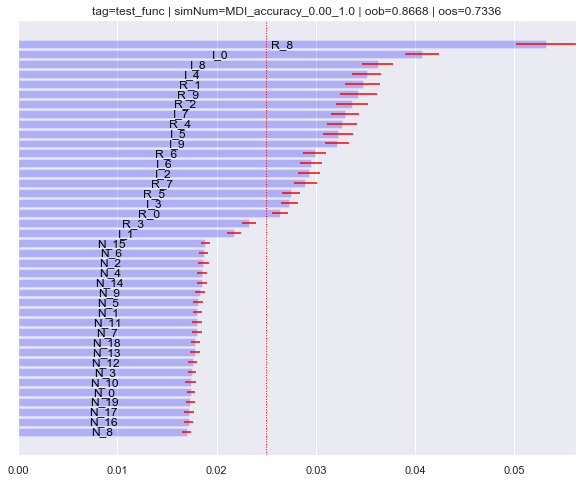

MDA_accuracy_0.00_1.0


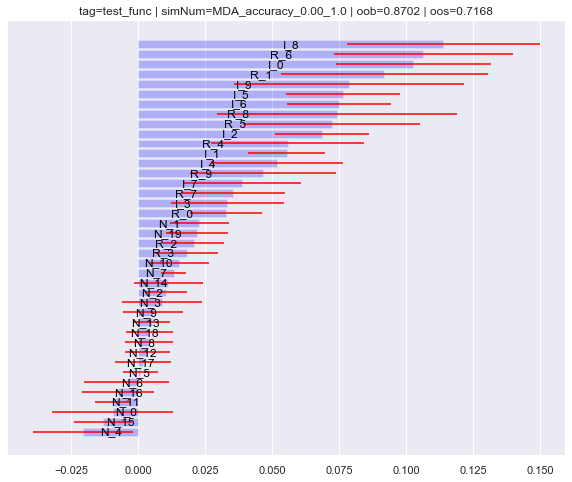

SFI_accuracy_0.00_1.0


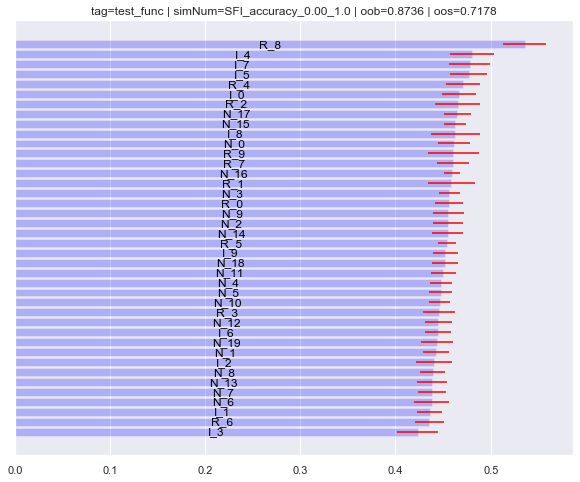

,method,scoring,minWLeaf,max_samples,I,R,N,oob,oos
1,MDA,accuracy,0.0,1.0,0.482089,0.384427,0.042874,0.8702,0.716818
0,MDI,accuracy,0.0,1.0,0.317249,0.324432,0.358319,0.8668,0.733617
2,SFI,accuracy,0.0,1.0,0.250527,0.255076,0.494397,0.8736,0.717820


In [47]:
test_func(n_samples=5000, cv=7)

## Exercises

### 1. Feature Importance on PCA dataset

I modified the `feat_importance` function so that user can decide whether to use bagged trees or random forest (which is what we need in this exercise). I generate a synthetic dataset, apply PCA to it, and then examine feature importance.

MDI:


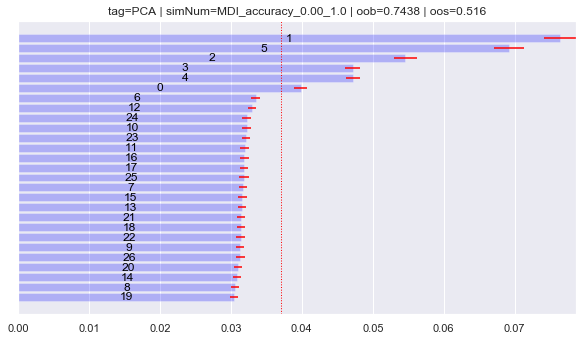

MDA:


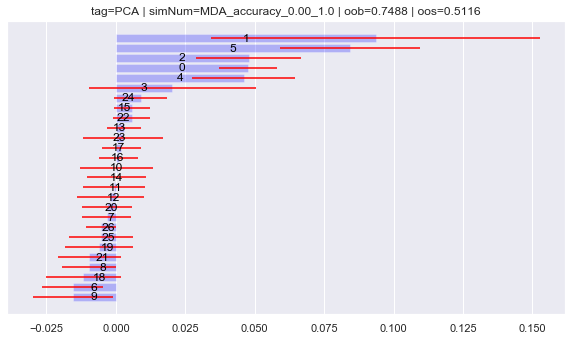

SFI:


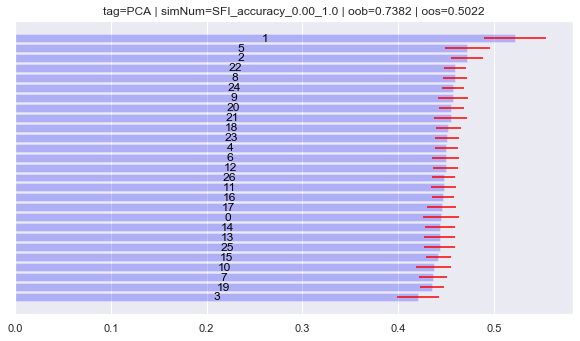

In [48]:
X, cont = get_test_data(n_features=40, n_informative=10, n_redundant=10, n_samples=5000)
y = cont['bin']

X_dot = ortho_feats(dfX=X, varThres=0.95)
X_dot.columns = [str(i) for i in X_dot.columns]
for method in ['MDI', 'MDA', 'SFI']:
    imp, oob, oos = feat_importance(trnsX=X_dot, cont=cont, n_estimators=100, cv=7, max_samples=1.0,
                                    pctEmbargo=0.0, scoring='accuracy', method=method,
                                    min_weight_fraction_leaf=0.0, ensemble='random forest')
    print(f'{method}:')
    plot_feat_importance(imp=imp, oob=oob, oos=oos, method=method, tag='PCA',
                         simNum=method + '_accuracy_0.00_1.0')

We can see that all 3 methods pretty much agree on the most important features - all of them have the same top3 features 1-5-2. These are the features from PCA that explain the most of the initial dataset's variance, so they are clearly very important and are likely to be spotted by each method.

### 2. Union of PCA and Initial Dataset

MDI:


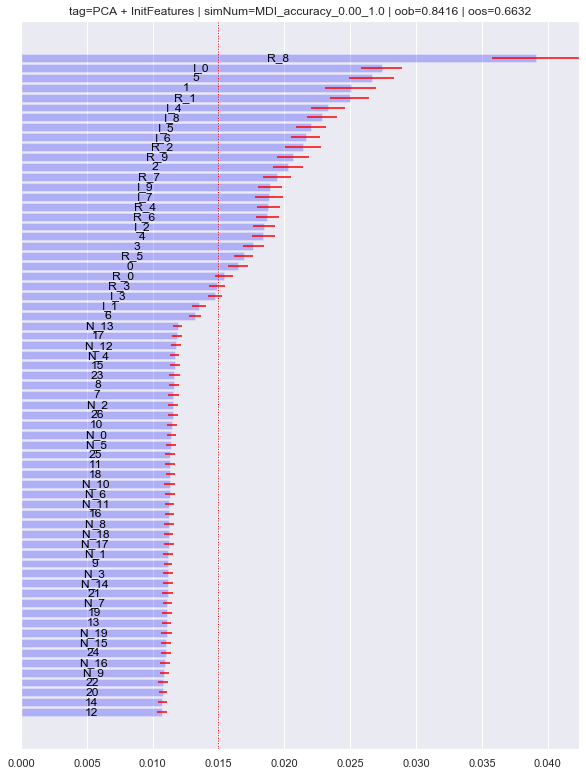

MDA:


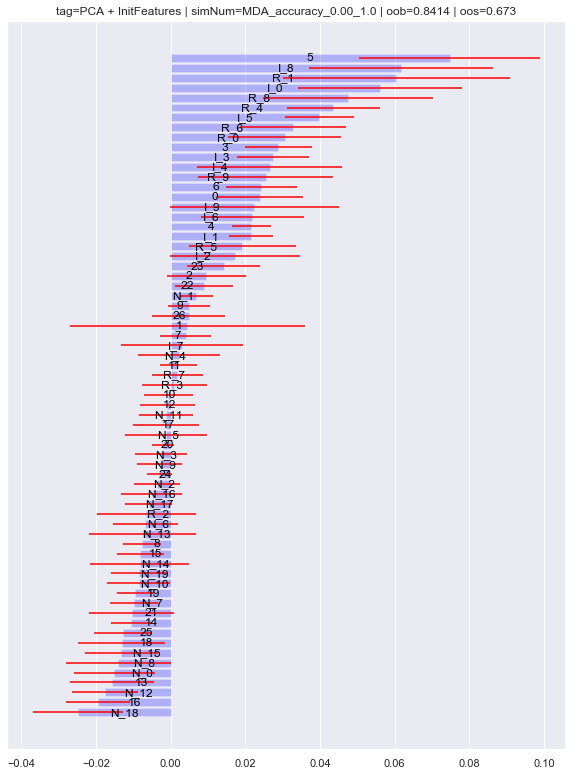

SFI:


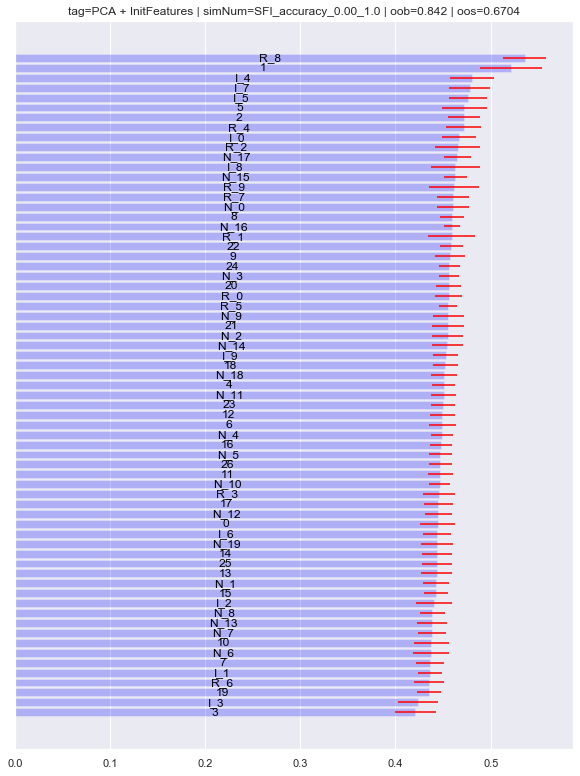

In [49]:
X_2dot = pd.concat([X, X_dot], axis=1)
for method in ['MDI', 'MDA', 'SFI']:
    imp, oob, oos = feat_importance(trnsX=X_2dot, cont=cont, n_estimators=100, cv=7, max_samples=1.0,
                                    pctEmbargo=0.0, scoring='accuracy', method=method,
                                    min_weight_fraction_leaf=0.0, ensemble='random forest')
    print(f'{method}:')
    plot_feat_importance(imp=imp, oob=oob, oos=oos, method=method, tag='PCA + InitFeatures',
                         simNum=method + '_accuracy_0.00_1.0')

Here the consensus is not so strong but still in all 3 methods there are almost the same feature in the top.

### 3. Dropping Important Features

Now we drop important features from `X_2dot` and see how the consensus between different methods of estimating importance changes. According to what we see in the previous exercise, let's drop features 1, 5, I_0, I_8, I_6, R_8:

MDI:


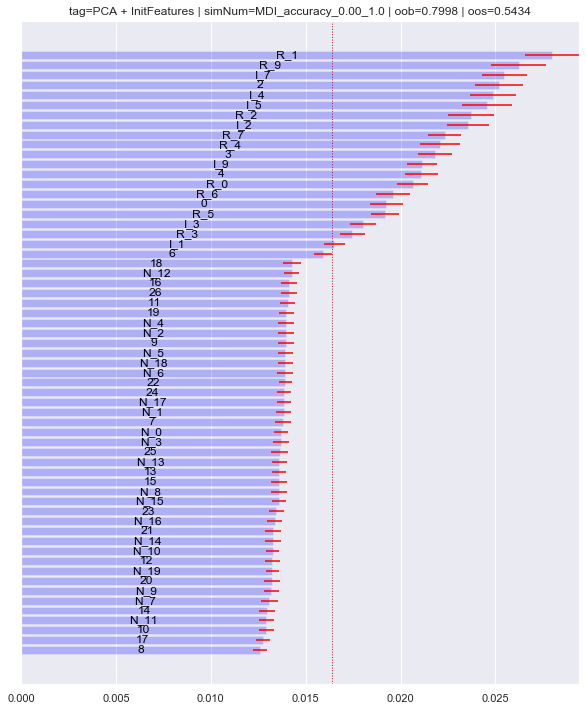

MDA:


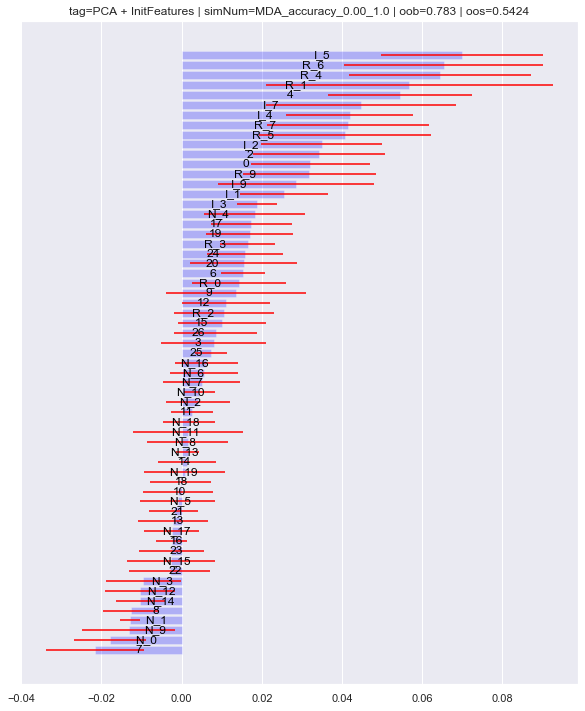

SFI:


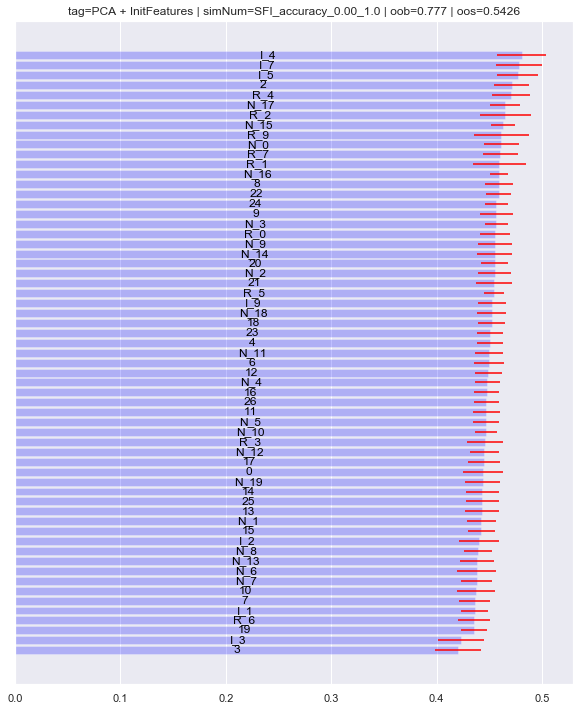

In [50]:
X_3dot = X_2dot.drop(['1', '5', 'I_0', 'I_8', 'I_6', 'R_8'], axis=1)
for method in ['MDI', 'MDA', 'SFI']:
    imp, oob, oos = feat_importance(trnsX=X_3dot, cont=cont, n_estimators=100, cv=7, max_samples=1.0,
                                    pctEmbargo=0.0, scoring='accuracy', method=method,
                                    min_weight_fraction_leaf=0.0, ensemble='random forest')
    print(f'{method}:')
    plot_feat_importance(imp=imp, oob=oob, oos=oos, method=method, tag='PCA + InitFeatures',
                         simNum=method + '_accuracy_0.00_1.0')

We can notice that once we dropped the features considered important by all 3 methods, the scatter of new important features becomes very high. There now only features that were not so important to classifiers, and methods can't agree on which of them to consider important now that really important features are dropped.

### 4. Parallelized vs Stacked Importance

In [57]:
X, cont = get_test_data(n_features=20, n_informative=5, n_redundant=5, n_samples=int(1e5))
X.columns = [str(i) for i in X.columns]
X = X.sample(frac=1)    # shuffle dataset
cont = cont.iloc[X.index, :]

First, we do parallelized feature importance - we split `X` into 10 datasets, calculate importances for each split and then take the mean results. Here I use `MDI` and `MDA` only as `SFI` is too slow.

MDI:


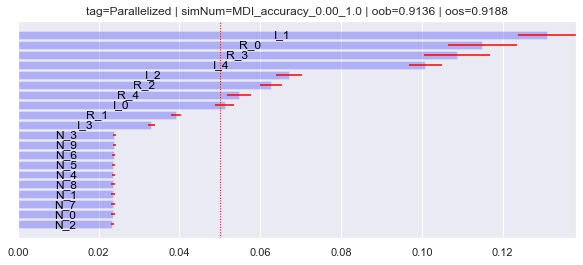

MDA:


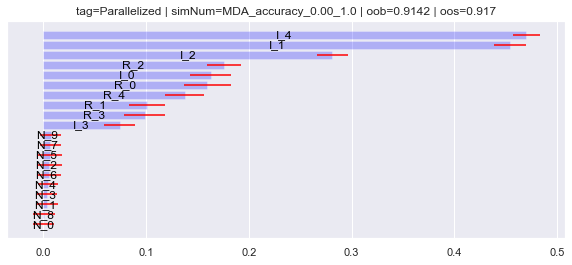

In [58]:
for method in ['MDI', 'MDA']:
    importances = pd.DataFrame(dtype=object)
    oobs = []
    ooss = []
    for split_num in range(1, 11):
        X_split = X[(split_num - 1) * 10000: split_num * 10000].reset_index(drop=True)
        cont_split = cont[(split_num - 1) * 10000: split_num * 10000].reset_index(drop=True)
        cont_split['t1'] = cont_split.index
        split_imp, oob, oos = feat_importance(trnsX=X_split, cont=cont_split, n_estimators=100, cv=7, max_samples=1.0,
                                              pctEmbargo=0.0, scoring='accuracy', method=method,
                                              min_weight_fraction_leaf=0.0, ensemble='random forest')
        split_imp.columns = ['mean_' + str(split_num), 'std_' + str(split_num)]
        importances = pd.concat([importances, split_imp], axis=1)
        oobs.append(oob)
        ooss.append(oos)

    mean = importances.iloc[:, ['mean' in i for i in importances.columns]].mean(axis=1)
    std = importances.iloc[:, ['std' in i for i in importances.columns]].mean(axis=1)
    imp = pd.concat([mean, std], axis=1).rename(columns={0: 'mean', 1: 'std'})
    print(f'{method}:')
    plot_feat_importance(imp=imp, oob=np.array(oobs).mean(), oos=np.array(oos).mean(), method=method,
                         tag='Parallelized', simNum=method + '_accuracy_0.00_1.0')

Now we do stacked feature importance - evaluate feature importance on `X` dataset as a whole.

MDI:


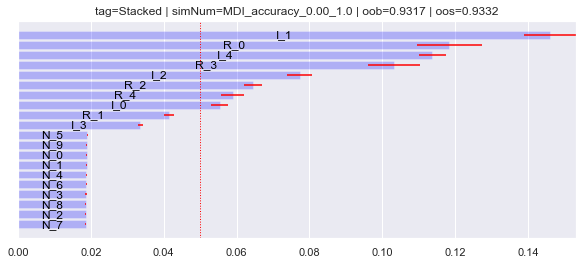

MDA:


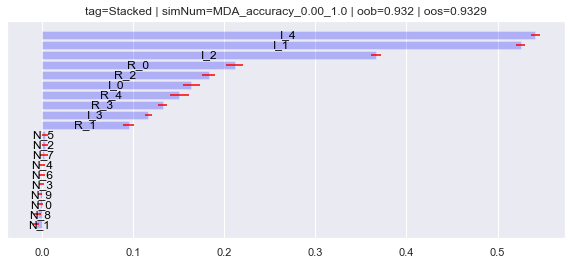

In [63]:
X = X.reset_index(drop=True)
cont = cont.reset_index(drop=True)
cont['t1'] = cont.index
for method in ['MDI', 'MDA']:
    imp, oob, oos = feat_importance(trnsX=X, cont=cont, n_estimators=100, cv=7, max_samples=1.0,
                                    pctEmbargo=0.0, scoring='accuracy', method=method,
                                    min_weight_fraction_leaf=0.0, ensemble='random forest')
    print(f'{method}:')
    plot_feat_importance(imp=imp, oob=oob, oos=oos, method=method, tag='Stacked',
                         simNum=method + '_accuracy_0.00_1.0')

We can notice that using the same method, parallelized and stacked versions give pretty much the same results - for both MDI and MDA top5 features are the same. However, stacked method can be considered more reliable. It is not affected by randomness of splits which can cause disbalanced samples and instead estimates the dataset as a whole.